In [2]:
import pandas as pd
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
with open('access.log', 'r', encoding='utf-8') as f:
    lines = f.readlines()

In [3]:
# 使用正規表達式，將每行 log 解析成對應欄位
pattern = re.compile(
    r'(?P<ip>\S+) - - \[(?P<time>.*?)\] "(?P<method>\S+) (?P<url>\S+) (?P<protocol>[^"]+)" (?P<status>\d{3}) (?P<size>\d+) "(?P<referrer>[^"]*)" "(?P<agent>[^"]*)"'   
)
records = []
for line in lines:
    match = pattern.match(line)
    if match:
        records.append(match.groupdict())

In [4]:
# 將解析後的紀錄轉成 DataFrame
df = pd.DataFrame(records)
# 將時間欄位轉換為 datetime 格式，並擷取小時數作為欄位 hour
df['time'] = pd.to_datetime(df['time'], format='%d/%b/%Y:%H:%M:%S %z')
df['hour'] = df['time'].dt.hour

In [5]:
# 統計出現次數最多的來源 IP
df['ip'].value_counts().head(10)

ip
66.249.66.194      353483
66.249.66.91       314522
151.239.241.163     92473
66.249.66.92        88332
91.99.30.32         45973
104.222.32.91       42058
91.99.72.15         38694
91.99.47.57         38609
5.78.190.233        37203
195.181.168.181     27979
Name: count, dtype: int64

In [6]:
# 找出常見的 bot User-Agent
df[df['agent'].str.contains('bot|spider', case=False)]['agent'].value_counts()

agent
Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.96 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)    450555
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)                                                                                                                                   197769
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                                                                                                                  191450
Googlebot-Image/1.0                                                                                                                                                                                       159118
Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)                                                                                            

<Axes: title={'center': 'request per hour'}, xlabel='hour'>

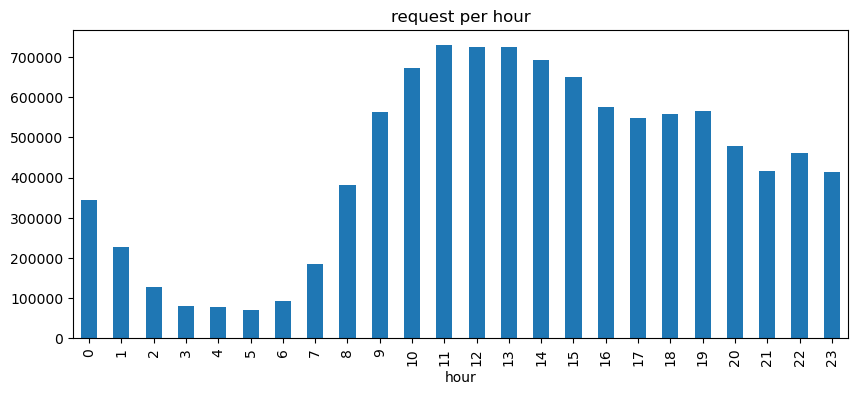

In [8]:
# 繪製每小時請求數統計圖
df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(10,4), title="request per hour")

In [9]:
# 統計 HTTP 回應狀態碼
df['status'].value_counts()

status
200    9579824
304     340228
302     199835
404     105011
301      67551
499      50852
500      14266
403       5634
502        798
400        529
401        323
408        112
504        103
405          6
206          3
Name: count, dtype: int64

In [10]:
# 哪些 URL 最常被存取
df['url'].value_counts().head(10)

url
/settings/logo                                352047
/static/css/font/wyekan/font.woff             280176
/static/images/guarantees/bestPrice.png       138010
/static/images/guarantees/fastDelivery.png    125689
/static/images/guarantees/warranty.png        124127
/static/images/guarantees/goodShopping.png    116653
/site/alexaGooleAnalitic                      103798
/favicon.ico                                  102731
/static/images/guarantees/support.png          98460
/static/images/amp/telegram.png                92409
Name: count, dtype: int64

In [11]:
# 單一 IP 嘗試連很多 URL
df.groupby('ip')['url'].nunique().sort_values(ascending=False).head(10)

ip
66.249.66.194      117379
66.249.66.91        93532
151.239.241.163     53309
104.222.32.91       40667
195.181.168.181     26343
195.181.168.164     22886
17.58.102.43        20902
91.99.30.32         20373
66.249.66.92        18983
5.78.190.233        17375
Name: url, dtype: int64

In [5]:
# 把 response size 轉成數字才能進模型
df['size'] = df['size'].astype(float)
features = df[['size', 'hour']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [10]:
iso = IsolationForest(contamination=0.001, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled) == -1

In [11]:
print(df[df['anomaly']])

                    ip                      time method  \
374      207.46.13.136 2019-01-22 03:57:31+03:30    GET   
978        89.47.79.75 2019-01-22 03:59:10+03:30    GET   
1036      95.81.118.56 2019-01-22 03:59:16+03:30    GET   
1301     207.46.13.104 2019-01-22 04:00:05+03:30    GET   
1610     207.46.13.136 2019-01-22 04:01:11+03:30    GET   
...                ...                       ...    ...   
9222456  91.99.213.141 2019-01-26 12:59:36+03:30    GET   
9222766  91.99.213.141 2019-01-26 12:59:42+03:30    GET   
9222918  91.99.213.141 2019-01-26 12:59:46+03:30    GET   
9223146  91.99.213.141 2019-01-26 12:59:49+03:30    GET   
9223408  91.99.213.141 2019-01-26 12:59:53+03:30    GET   

                                                       url  protocol status  \
374                      /image/32352?name=7980.jpg&wh=max  HTTP/1.1    200   
978                /static/bundle-bundle_site_defer.min.js  HTTP/1.1    200   
1036               /static/bundle-bundle_site_defer.mi